## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
logging.getLogger().setLevel(logging.INFO)

import pandas as pd

from trace import Trace

In [2]:
trace_path = "../../results_latest/rtapp::{}/1/trace.dat".format("three-twentypercent")

import json
import os

import trappy

platform_json_path = os.path.join(os.path.dirname(trace_path), "../platform.json")

with open(platform_json_path) as f:
    platform = json.load(f)
    
trace = Trace(platform, trace_path, ["sched_load_avg_cpu", "sched_load_avg_task", "sched_overutilized", "cpu_frequency", "cpu_idle", "sched_switch"],
                 normalize_time=False)

INFO:root:Parsing FTrace format...
INFO:root:Platform clusters verified to be Frequency coherent
INFO:root:Collected events spans a 9.487 [s] time interval
INFO:root:Overutilized time: 0.678652 [s] (7.154% of trace time)
INFO:root:Set plots time range to (92.581421, 102.068088)[s]
INFO:root:Registering trace analysis modules:
INFO:root:   tasks
INFO:root:   eas
INFO:root:   latency
INFO:root:   frequency
INFO:root:   functions
INFO:root:   idle
INFO:root:   status
INFO:root:   cpus


## Plot Schedule

In [3]:
print "tracing " + os.path.realpath(trace_path)
trappy.plotter.plot_trace(trace.ftrace)

tracing /vagrant/results/20161025_165524/rtapp::three-twentypercent/1/trace.dat


## View energy estimation
`estimate_from_trace` uses the energy model to produce a trace of estimated power of each system component.
Each column is headed by a tuple with the CPUs in the component (CPU or cluster) represented. The "power" column contains the sum of the other columns.

In [4]:
from platforms.juno_energy import juno_energy
power_df = juno_energy.estimate_from_trace(trace)

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2824: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
INFO:root:   EnergyModel - Estimating energy from trace - 4853 events...
INFO:root:   EnergyModel - Done.


Now plot the energy of each component. The `cumsum` along axis 1 (the horizontal axis) means that the plots for each component are stacked. Working out which line is which is left as an exercise to the reader. Also we should fill under the lines with 100% opacity but I can't get the JS library to do that for me.

In [5]:
import numpy as np

In [6]:
df = power_df.drop("power", 1).apply(np.cumsum, axis=1)
print df.columns
from trappy.plotter.ILinePlotGen import ILinePlotGen
gen = ILinePlotGen(2, per_line=1, title="power", 
                   max_datapoints={}, step_plot=True, fill=False, scatter=None, point_size=1000)
gen.add_plot(1, df)
gen.finish()

Index([(0,), (1,), (2,), (3,), (4,), (5,), (0, 3, 4, 5), (1, 2)], dtype='object')


""
""
""
""


## Find which resources over-used energy

Sum the energy used by each component over the period of workload execution.

In [7]:
from bart.common.Utils import select_window, area_under_curve

In [14]:
# TODO don't hardcode this window
window = (94.499114, 99.380948)
df_windowed = select_window(power_df, window)
columns = list(df_windowed.columns)
columns.remove("power")
estimated = {}
for column in columns:
    estimated[column] = area_under_curve(df_windowed[column]) / (window[1] - window[0])
estimated

{(0,): 17.489012530946976,
 (0, 3, 4, 5): 33.648137667114497,
 (1,): 2.2512955172171973,
 (1, 2): 24.065011530502606,
 (2,): 0.26910337385506733,
 (3,): 20.109273789317179,
 (4,): 34.502222115703859,
 (5,): 35.05569361842246}

Get expected (ideal) energy usage

In [15]:
u = 0.8 * 1024
util  = [0, u, u, 0, 0, 0]
expected = juno_energy.estimate_from_cpu_util((204.8, 0, 0, 0, 204.8, 204.8))
del expected["power"]
# estimate_from_cpu_util returns with an "idle" field and an "active" field, add them up
expected = { k: sum(v.values()) for k, v in expected.iteritems() }
expected

{(0,): 29.53021276595745,
 (0, 3, 4, 5): 29.855319148936168,
 (1,): 0.0,
 (1, 2): 24.0,
 (2,): 0.0,
 (3,): 0.0,
 (4,): 29.53021276595745,
 (5,): 29.53021276595745}

Show how much extra energy each component seemed to use

In [17]:
extra = estimated[(1, 2)] + estimated[(1,)] + estimated[(2,)] - 24
total = sum(estimated.values())
extra / total

0.015445452420861719

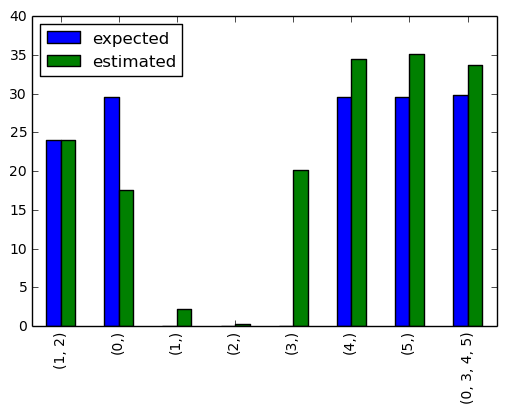

In [18]:
df_exp = pd.DataFrame(expected.values(), index=expected.keys())
df_est = pd.DataFrame(estimated.values(), index=estimated.keys())
df = pd.concat([df_exp, df_est], axis=1)
df.columns = ["expected", "estimated"]
df.plot(kind="bar")

INFO:root:LITTLE cluster average frequency: 0.569 GHz
INFO:root:big    cluster average frequency: 0.497 GHz


(0.56920572677120096, 0.49702143270865839)

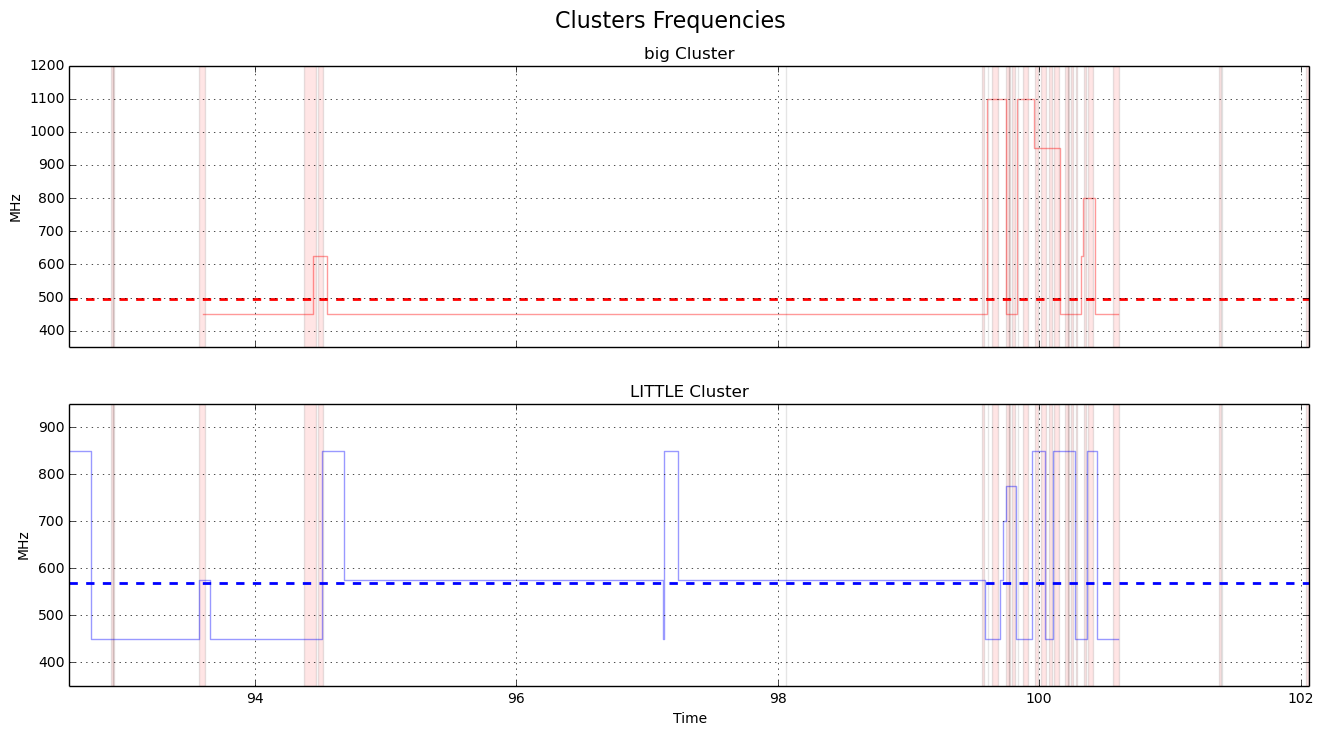

In [12]:
trace.analysis.frequency.plotClusterFrequencies()

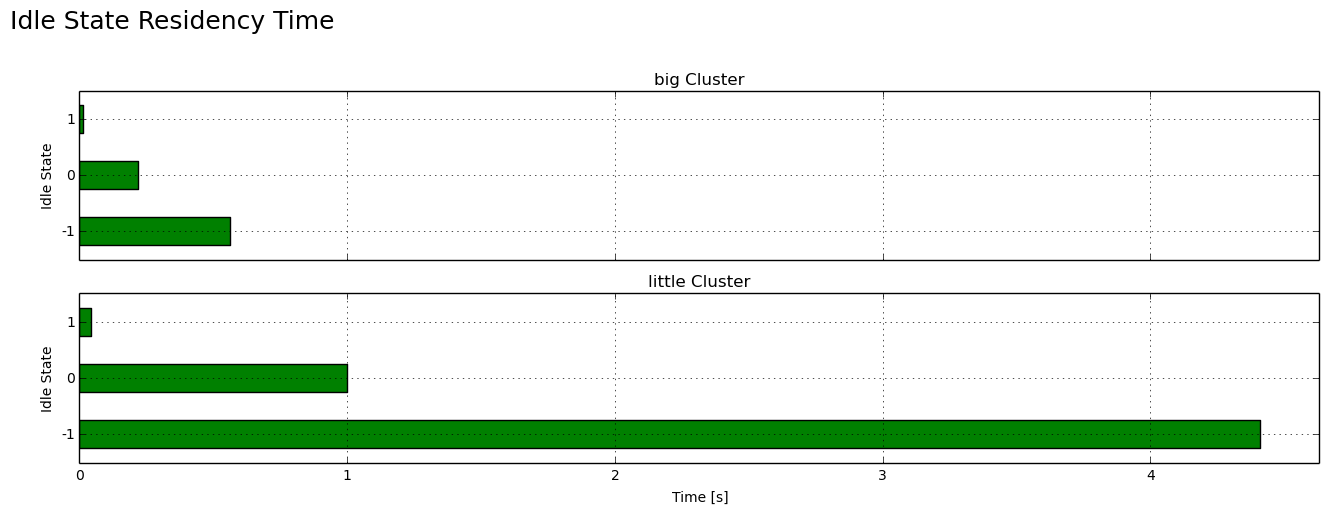

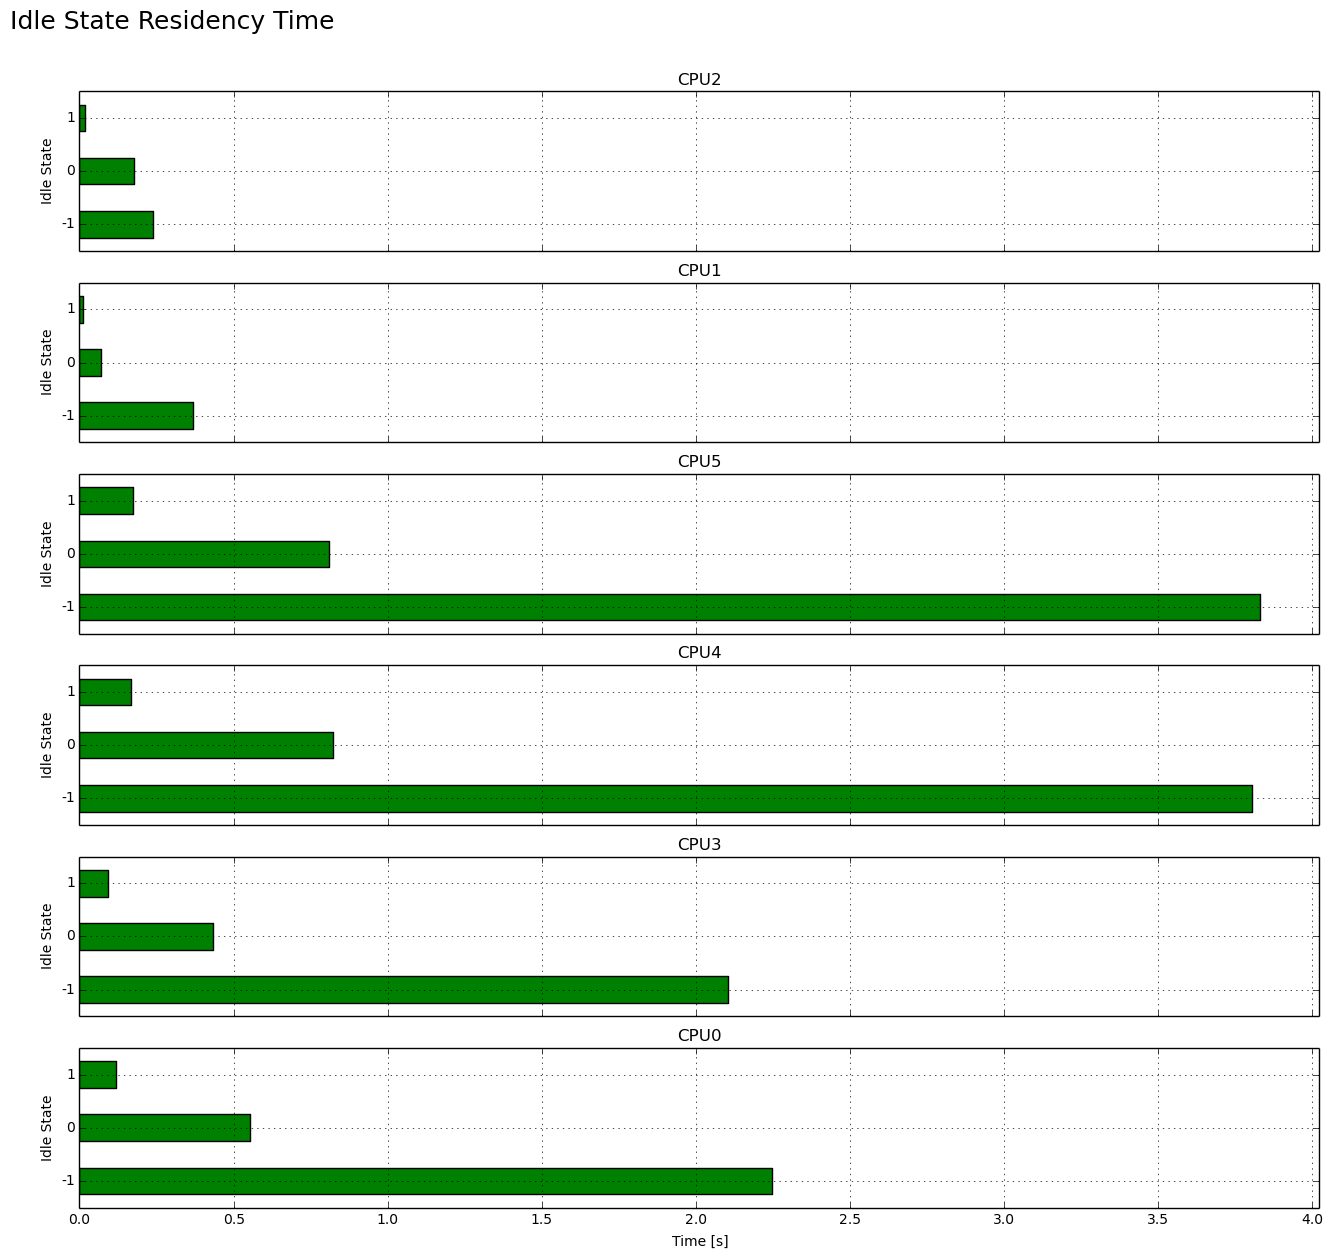

In [13]:
trace.analysis.idle.plotClusterIdleStateResidency()
trace.analysis.idle.plotCPUIdleStateResidency()